# Caselaw Access Project
## bulk export case text processing

This demo is designed to get you up and running with a sample of CAP data from https://case.law/download/bulk_exports/.

Feel free to reuse, modify, or distribute it however you'd like. **Most of this code is written to be adaptable to 
different chunks of CAP data!** You can substitute in another file corresponding to a different jurisdiction or mess
around with any number of other parameters.

Python imports:

In [7]:
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import lzma
import json
import requests
from tqdm import tqdm
%matplotlib inline

## Downloading data
First let's download the latest text export for the state of North Carolina. You could also download files
manually from your browser.

In [8]:
download_url = "https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/nc/nc_text.zip"
output_path = "data/nc_text.zip"
print("Downloading to %s ..." % output_path)
with open(output_path, 'wb') as out_file:
    shutil.copyfileobj(requests.get(download_url, stream=True).raw, out_file)
print("Done.")


Done.


# Loading data

Our bulk export is stored as a zipped folder in [BagIt](https://en.wikipedia.org/wiki/BagIt) format, which in turn
contains an xzipped file in [jsonlines](http://jsonlines.org/) format. We can peel off all of those layers and get
a list of cases with built-in Python libraries.

Let's pull 1-year batches of cases at 10 year intervals from 1900 to 2000. This should give us a good sampling over time.

In [9]:
# a list to hold the cases we're sampling
cases = []

# decompress the file line by line
with zipfile.ZipFile('data/nc_text.zip', 'r') as zip_archive:
    xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
    with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
        for line in tqdm(jsonlines):
            # decode the file into a convenient format
            record = json.loads(str(line, 'utf-8'))
            # if the decision date on the case matches one we're interested in, add to our list
            if int(record['decision_date'][:4]) in range(1900, 2010, 10):
                cases.append(record)

print("Number of Cases: {}".format(len(cases)))

97600it [00:20, 4706.15it/s]


Number of Cases: 7100


# Analyzing case metadata
Let's take a look at the case format by accessing the first entry in our list of matching cases.

In [10]:
cases[0]

{'id': 11272927,
 'url': 'https://api.capapi.org/v1/cases/11272927/',
 'name': 'ARTHUR COUNCIL v. R. PRIDGEN and F. M. WRAY',
 'name_abbreviation': 'Council v. Pridgen',
 'decision_date': '1910-11-17',
 'docket_number': '',
 'first_page': '443',
 'last_page': '457',
 'citations': [{'cite': '153 N.C. 443', 'type': 'official'}],
 'volume': {'volume_number': '153',
  'barcode': '32044057888323',
  'url': 'https://api.capapi.org/v1/volumes/32044057888323/'},
 'reporter': {'id': 549,
  'full_name': 'North Carolina Reports',
  'url': 'https://api.capapi.org/v1/reporters/549/'},
 'court': {'name_abbreviation': 'N.C.',
  'name': 'Supreme Court of North Carolina',
  'id': 9292,
  'slug': 'nc',
  'url': 'https://api.capapi.org/v1/courts/nc/'},
 'jurisdiction': {'name': 'N.C.',
  'id': 5,
  'slug': 'nc',
  'name_long': 'North Carolina',
  'url': 'https://api.capapi.org/v1/jurisdictions/nc/',
  'whitelisted': True},
 'cites_to': [],
 'frontend_url': 'https://cite.capapi.org/nc/153/443/',
 'preview

A lot of info here, but it's quite messy. Let's pull out a few case metadata attributes we're interested in, leaving the actual case text aside for now – the decision date (year only), case name, case citation, court, and opinion count. We'll put them into a Pandas Dataframe for easier manipulation. 

In [11]:
# use a list comprehension to pull out the metadata attributes specified above
case_metadata = [{'year': int(case['decision_date'][:4]),
                'name': case['name'],
                'citation': case['citations'][0]['cite'],
                'court': case['court']['name'],
                'opinion_count': len(case['casebody']['data']['opinions'])} 
                 for case in cases]

# lists of dictionaries like `case_metadata` convert easily into Dataframes
metadata_df = pd.DataFrame(case_metadata)
metadata_df.head()

,year,name,citation,court,opinion_count
0,1910,ARTHUR COUNCIL v. R. PRIDGEN and F. M. WRAY,153 N.C. 443,Supreme Court of North Carolina,2
1,1910,T. S. MYERS v. C. G. PETTY et al.,153 N.C. 462,Supreme Court of North Carolina,1
2,1910,W. A. UNDERWOOD v. TOWN OF ASHEBORO,152 N.C. 641,Supreme Court of North Carolina,1
3,1910,J. O. RICH v. ASHEVILLE ELECTRIC COMPANY,152 N.C. 689,Supreme Court of North Carolina,2
4,1910,S. L. CROWELL et al. v. THE CITY OF MONROE,152 N.C. 399,Supreme Court of North Carolina,2


Yay, we've got our first usable data! As minimal as this metadata is, we should still be able to get some useful insights out of it. First, let's check how many cases we have from each year in our sample.

In [12]:
metadata_df['year'].value_counts().sort_index()

1900     419
1910     394
1920     348
1930     514
1940     391
1950     329
1960     348
1970     838
1980    1375
1990    1052
2000    1092
Name: year, dtype: int64

There's clearly a lot of variation in publication volume year to year, with pronounced increases over time. Let's break it down by court.

In [13]:
metadata_df['court'].value_counts().sort_index()

North Carolina Court of Appeals                                   2324
Supreme Court of North Carolina                                   4775
United States Circuit Court for the District of North Carolina       1
Name: court, dtype: int64

The cases in our sample are are mostly from the North Carolina Court of Appeals or Supreme Court of North Carolina,
primarily the latter. Let's look at the number of opinions per case.

In [14]:
metadata_df['opinion_count'].value_counts().sort_index()

1    6628
2     419
3      49
4       3
5       1
Name: opinion_count, dtype: int64

The majority of our cases have a single opinion (i.e. no dissent or concurrence). Let's try to identify some trends in
opinion volume over time.

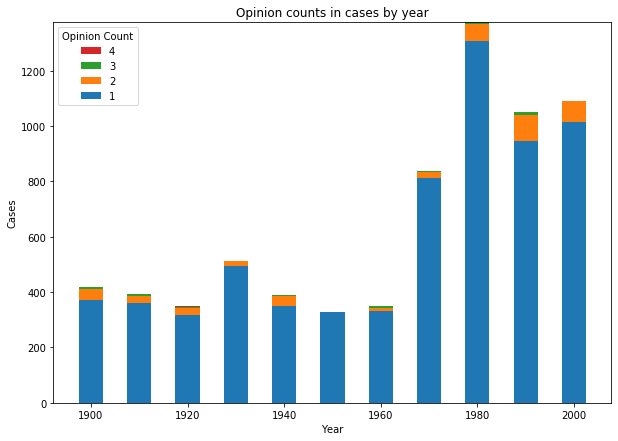

In [15]:
# get frequency of opinion counts for each year
n_opinions = [[year, 
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 1)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 2)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] == 3)].shape[0],
               metadata_df[(metadata_df['year'] == year) & (metadata_df["opinion_count"] >= 4)].shape[0]]
              for year in metadata_df['year'].unique()]

# reformat for graph
n_opinions = list(zip(*n_opinions))
n_opinions = [list(item) for item in n_opinions]
plt.figure(figsize=(10,7))

ind = n_opinions[0]
handles = []
for i, count in enumerate(n_opinions[1:]):
    bot = n_opinions[1:i+1]
    bot = [sum(x) for x in zip(*n_opinions[1:i+1])]
    bot = [0]*len(ind) if not bot else bot
    h = plt.bar(ind, count, 5, bottom=bot, label=i+1)
    handles.append(h)
    
plt.legend(handles=handles[::-1], title="Opinion Count")
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title("Opinion counts in cases by year")
plt.show()

Interesting – it seems that cases from 1980, 1990, and 2000 tend to have more opinions than those from earlier years in 
the sample.

## Analyzing case text

Now let's get to the rich part of the dataset – the opinions themselves! These are a bit messier to wrangle than the 
metadata was. There are a couple ways that we might structure our dataframe, but to keep it simple we'll just do one 
opinion per row. If a case has multiple opinions, each will be a separate row (linked by the case id).

In [16]:
#Loop through cases and build rows with case metadata AND opinion metadata/text.
#We load in all of the keys initially, then modify the ones we want to.

opinion_data = []
for case in cases:
    for opinion in case["casebody"]["data"]["opinions"]:
        opinion_data.append({
            'id': case['id'],
            'name': case['name'],
            'decision_date': int(case['decision_date'][:4]),
            'court': case['court']['name'],
            'citation': case['citations'][0]['cite'],
            'author': opinion['author'],
            'type': opinion['type'],
            'text': opinion['text'],
        })

opinions_df = pd.DataFrame(opinion_data)
opinions_df.head()

,id,name,decision_date,court,citation,author,type,text
0,11272927,ARTHUR COUNCIL v. R. PRIDGEN and F. M. WRAY,1910,Supreme Court of North Carolina,153 N.C. 443,"Hoije, J.",majority,"Hoije, J.\nOur Constitution, Article X, see. 6..."
1,11272927,ARTHUR COUNCIL v. R. PRIDGEN and F. M. WRAY,1910,Supreme Court of North Carolina,153 N.C. 443,"Glare:, O. J.,",dissent,"Glare:, O. J.,\ndissenting. The sole question ..."
2,11272980,T. S. MYERS v. C. G. PETTY et al.,1910,Supreme Court of North Carolina,153 N.C. 462,"MANNING, J.",majority,"MANNING, J.\nIt may be conceded that the evide..."
3,11272340,W. A. UNDERWOOD v. TOWN OF ASHEBORO,1910,Supreme Court of North Carolina,152 N.C. 641,"Clark, C. J.",majority,"Clark, C. J.\nUpon the facts agreed, which the..."
4,11272575,J. O. RICH v. ASHEVILLE ELECTRIC COMPANY,1910,Supreme Court of North Carolina,152 N.C. 689,"Manning, J.,",majority,"Manning, J.,\nafter stating the case: Construi..."


After dropping some extraneous information, we're left with a number of useful attributes for each opinion:

- id (assigned by CAP database): A unique case identifier that we can use to link opinions belonging to the same case
- name: The case's name
- court: The court in which the case was heard and decided
- citations: The official citation to the case
- author: The author of the opinion, if known
- type: The type of the opinion (ex. 'majority,''dissent,''concurrence')
- text: The full text of the opinion

Let's try to a more complicated question using this corpus. Comparing cases from 1900, 1910, 1920, and 1930 against cases from 1970, 1980, 1990, and 2000, what words can we say are distinctive to each time period? Are there words from opinions dating to the beginning of the 20th century that don't occur in opinions dating to the end of the 20th century?

We'll start by implementing a basic n-gram search function and graphing our results. 

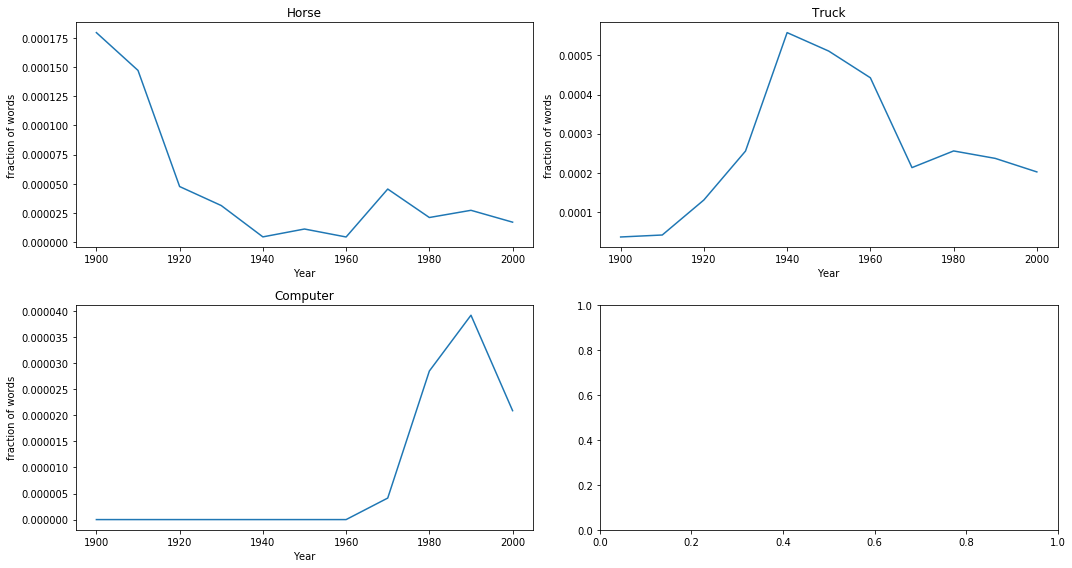

In [17]:
def search_ngram(ngram):
    pairs = []
    for year in opinions_df["decision_date"].unique():
        temp = opinions_df[opinions_df["decision_date"] == year]["text"].tolist()
        temp = " ".join(temp).lower()
        n = len(temp.split(" "))
        ngram_count = temp.count(ngram.lower())
        pairs.append((year, ngram_count/n))
    pairs.sort()
    return pairs

def graph_ngram(pairs, ax, title):
    x,y = [list(x) for x in zip(*pairs)]
    ax.plot(x,y)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("fraction of words")
    return ax

fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("horse"), axes[0,0], "Horse")
graph_ngram(search_ngram("truck"), axes[0,1], "Truck")
graph_ngram(search_ngram("computer"), axes[1,0], "Computer")
plt.tight_layout()
plt.show()

Let's get a little bit more sophisticated (still keeping it simple) and find a list of words which occur fewer than 10 
times in cases from 1900-1940 but frequently in cases from 1970-2000.

In [18]:
def tokenize_cases(cases):
    cases = " ".join(cases).lower()
    cases = cases.replace("\n", " ").replace(",", "").replace(";", "").replace("'", "").replace("’", "")
    cases = cases.replace("(", "").replace(")", "").replace(".", "").replace("?", "").replace("!", "").split(" ")
    return cases

early_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] <= 1930]["text"].tolist())
late_cases = tokenize_cases(opinions_df[opinions_df["decision_date"] >= 1970]["text"].tolist())

early_cases_dict = {}

for word in early_cases:
    if word in early_cases_dict:
        early_cases_dict[word] += 1
    else:
        early_cases_dict[word] = 1

new_words_dict = {}

for word in late_cases:
    if word in early_cases_dict:
        if early_cases_dict[word] < 10:
            if word in new_words_dict:
                new_words_dict[word] += 1
            else:
                new_words_dict[word] = 1
    else:
        if word in new_words_dict:
            new_words_dict[word] += 1
        else:
            new_words_dict[word] = 1

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

sorted_new_words = sorted(new_words_dict.items(), key=lambda x:-x[1])
sorted_new_words = [item for item in sorted_new_words if not isInt(item[0])]
sorted_new_words = sorted_new_words[:100]

print("Most common words from 1970-2000 that occured <10 times from 1900-1930\n")
print ("{0:14}|{1:5}".format("Word", "Occurances"))
print ("-------------------------")
for word in sorted_new_words:
    print ("{0:14}|{1:5}".format(word[0], word[1]))

Most common words from 1970-2000 that occured <10 times from 1900-1930

Word          |Occurances
-------------------------
nc            |32919
se2d          |18903
§             |10143
gs            | 8984
ncgs          | 3312
gen           | 2949
argues        | 2923
victim        | 2355
cert          | 1788
emphasis      | 1536
coverage      | 1254
mitigating    | 1247
victims       | 1199
disagree      | 1148
disc          | 1119
robbery       | 1114
7a-31         | 1090
sentencing    | 1065
sexual        |  922
aggravating   |  896
factors       |  879
first-degree  |  878
1a-1          |  855
cocaine       |  737
eg            |  736
dire          |  701
voir          |  700
sct           |  692
cir           |  677
spouse        |  649
factual       |  623
workers       |  613
“[t]he        |  607
pm            |  596
sub           |  595
[the          |  590
asserts       |  560
emotional     |  559
judice        |  549
procedures    |  536
reveals       |  533
additionally  |

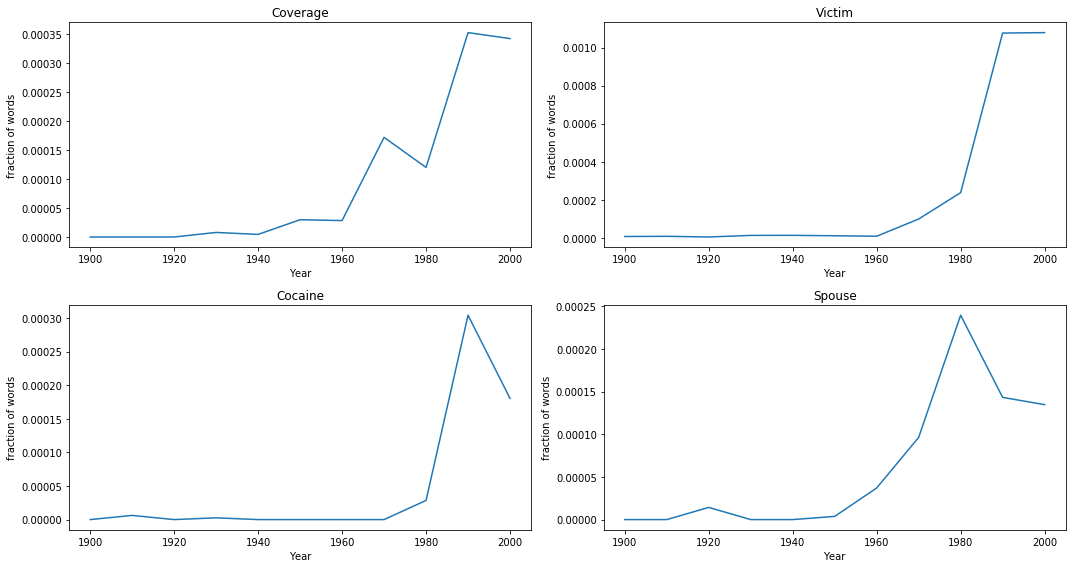

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(15,8))
graph_ngram(search_ngram("coverage"), axes[0,0], "Coverage")
graph_ngram(search_ngram("victim"), axes[0,1], "Victim")
graph_ngram(search_ngram("cocaine"), axes[1,0], "Cocaine")
graph_ngram(search_ngram("spouse"), axes[1,1], "Spouse")

plt.tight_layout()
plt.show()

